# Recurrent Neural Networks (RNN)

&copy; 李浩东 3190104890@zju.edu.cn

- Sequence Models
- Text Preprocessing
- Language Models and the Dataset
- Recurrent Neural Networks


$$
x_{t} \sim P\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right)
$$

- Music, speech, text, and videos are all sequential in nature. If we were to permute them they would make little sense. The headline dog bites man is much less surprising than man bites dog, even though the words are identical.

- In order to achieve this, we could use a regression model.

$$
x_{t} \sim P\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right) \sim P\left(x_{t} \mid x_{t-1},  x_{t-2},\ldots, x_{t-\tau}\right)
$$

- Such models will be called autoregressive models, as they quite literally perform regression on themselves.

- The second strategy, shown in the figure below, is to keep some summary $h_t$ of the past observations, and at the same time update $h_t$ in addition to the prediction $\hat{x}_{t}$. This leads to models that estimate ${x}_{t}$ with $\hat{x}_{t}=P\left(x_{t} \mid h_{t}\right)$ and moreover updates of the form $h_{t}=g\left(h_{t-1}, x_{t-1}\right)$. Since $h_t$ is never observed, these models are also called latent autoregressive models.

![sequence-model.svg](./images/8/sequence-model.svg)


- Both cases raise the obvious question of how to generate training data. One typically uses historical observations to predict the next observation given the ones up to right now. Obviously we do not expect time to stand still. However, a common assumption is that while the specific values of $x_t$ might change, at least the dynamics of the sequence itself will not. This is reasonable, since novel dynamics are just that, novel and thus not predictable using data that we have so far. Statisticians call dynamics that do not change stationary. Regardless of what we do, we will thus get an estimate of the entire sequence via:

$$
P\left(x_{1}, \ldots, x_{T}\right)=\prod_{t=1}^{T} P\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right)
$$

- Note that the above considerations still hold if we deal with discrete objects, such as words, rather than continuous numbers. The only difference is that in such a situation we need to use a classifier rather than a regression model to estimate it.

# Markov Models

- Recall the approximation that in an autoregressive model we use only $x_{t-1}, \ldots, x_{t-\tau}$ instead of $x_{t-1}, \ldots, x_{t-1}$ to estimate $x_t$. Whenever this approximation is accurate we say that the sequence satisfies a Markov condition. In particular, if $\tau=1$, we have a first-order Markov model and $P(x)$ is given by:

$$
P\left(x_{1}, \ldots, x_{T}\right)=\prod_{t=1}^{T} P\left(x_{t} \mid x_{t-1}\right) \text { where } P\left(x_{1} \mid x_{0}\right)=P\left(x_{1}\right)
$$


- Such models are particularly nice whenever $x_t$ assumes only a discrete value, since in this case dynamic programming can be used to compute values along the chain exactly. For instance, we can compute $P\left(x_{t+1} \mid x_{t-1}\right)$ efficiently:
 
$$
\begin{aligned}
P\left(x_{t+1} \mid x_{t-1}\right) &=\frac{\sum_{x t} P\left(x_{t+1}, x_{t}, x_{t-1}\right)}{P\left(x_{t-1}\right)} \\
&=\frac{\sum_{x t} P\left(x_{t+1} \mid x_{t}, x_{t-1}\right) P\left(x_{t}, x_{t-1}\right)}{P\left(x_{t-1}\right)} \\
&=\sum_{x_{t}} P\left(x_{t+1} \mid x_{t}\right) P\left(x_{t} \mid x_{t-1}\right)
\end{aligned}
$$


- In fact, if we have a Markov model, we can obtain a reverse conditional probability distribution, too. In many cases, however, there exists a natural direction for the data, namely going forward in time. It is clear that future events cannot influence the past. Hence, if we change $x_t$, we may be able to influence what happens for $x_{t+1}$ going forward but not the converse. That is, if we change $x_t$, the distribution over past events will not change. Consequently, it ought to be easier to explain $P\left(x_{t+1} \mid x_{t}\right) $
 rather than $P\left(x_{t} \mid x_{t+1}\right) $.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils import data
print(torch.__version__)

1.11.0


(1.0, 1000.0)

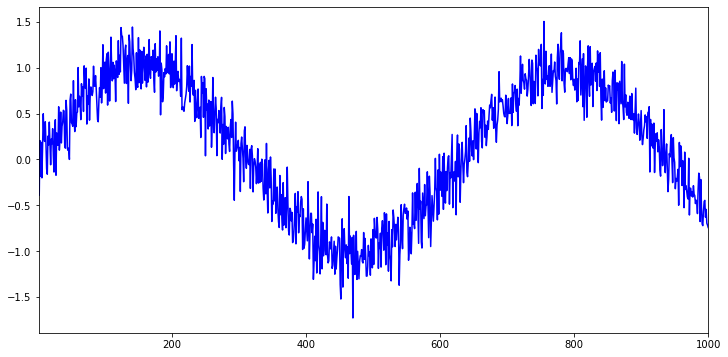

In [17]:
T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
plt.figure(figsize=(12, 6))
plt.plot(time, x, '-b')
plt.xlim(1, 1000)

In [13]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))
num_workers = 0
batch_size, n_train = 16, 600
train_loader = DataLoader(dataset=data.TensorDataset(features[:n_train], labels[:n_train]), 
                          batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataiter = iter(train_loader)

In [14]:
# Function for initializing the weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# A simple MLP
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# Note: `MSELoss` computes squared error without the 1/2 factor
loss = nn.MSELoss(reduction='none')

In [15]:
def evaluate_loss(net, data_iter, loss):
    l = 0
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l += loss(out, y)/len(X)
    return l/len(data_iter)
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        cur_loss = 0
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print("Epoch ->", epoch + 1, "\t\tLoss ->", evaluate_loss(net, train_iter, loss) * 100, "%")

net = get_net()
train(get_net(), dataiter, loss, 5, 0.01)

Epoch -> 1 		Loss -> 0.0 %
Epoch -> 2 		Loss -> 0.0 %
Epoch -> 3 		Loss -> 0.0 %
Epoch -> 4 		Loss -> 0.0 %
Epoch -> 5 		Loss -> 0.0 %


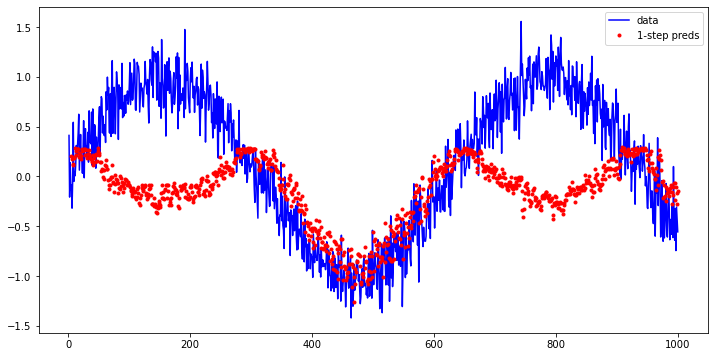

In [16]:
onestep_preds = net(features)
plt.figure(figsize=(12, 6))
plt.plot(time, x.detach().numpy(), '-b')
plt.plot(time[tau:], onestep_preds.detach().numpy(), '.r')
plt.legend(['data', '1-step preds'])